In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import datetime
from datetime import datetime as dt
import seaborn as sns
sns.set(style = "whitegrid")

In [2]:
# Source for testing small sample: http://web.mta.info/developers/turnstile.html
def get_sample_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [191130,191123,191116,191109,191102,191026,191019,191012,191005,190928,190921,190914,190907,190831]
turnstiles_df = get_sample_data(week_nums)
turnstiles_df = turnstiles_df.reset_index(drop=True)

In [3]:
# Remove and recovery audit rows (DESC = "RECOVR AUD")
turnstiles_df = turnstiles_df[turnstiles_df["DESC"] == "REGULAR"]

In [4]:
# Convert Date_TIME field to datetime and create DAY_NAME column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df["DATE"] + " " + turnstiles_df["TIME"], format="%m/%d/%Y %H:%M:%S")
turnstiles_df["DAY_Name"] = turnstiles_df["DATE_TIME"].dt.day_name()

In [5]:
# Make all columns upperspace and remove whitespace
turnstiles_df.columns = [column.strip().upper() for column in turnstiles_df.columns]

In [6]:
turnstiles_df.shape

(2869522, 13)

In [7]:
# Remove the weekends, focusing only on work days
df_weekdays = turnstiles_df[~turnstiles_df["DAY_NAME"].isin(["Saturday", "Sunday"])]

In [8]:
# Ensure all weekend rows were dropped
df_weekdays["DAY_NAME"].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [9]:
# Create unique identifier for each turnstile
df_weekdays['Turnstile'] = df_weekdays['C/A'] + df_weekdays['UNIT'] + df_weekdays['SCP']

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Get rid of the duplicate entry
df_weekdays.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df_weekdays.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [100]:
df_weekdays.shape

(2057741, 14)

In [11]:
# 
df_weekdays[["PREV_DATE", "PREV_ENTRIES"]] = (df_weekdays
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
df_weekdays[["PREV_DATE", "PREV_EXITS"]] = (df_weekdays
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [13]:
# Drop the rows for the earliest date in the df
df_weekdays.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number significantly smaller than 1 million as the limit!

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

df_weekdays["HOURLY_ENTRIES"] = df_weekdays.apply(get_daily_counts, axis=1, max_counter=100000)

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number significantly smaller than 1 million as the limit!

def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

df_weekdays["HOURLY_EXITS"] = df_weekdays.apply(get_daily_counts, axis=1, max_counter=100000)

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# Limit data to hour timestamps between 7:00 and 11:00 AM
df_final = df_weekdays[(df_weekdays["TIME"] >= "07:00:00") & (df_weekdays["TIME"] <= "11:00:00")]

In [17]:
df_final['HOURLY_ENTRIES'].describe()

count    396925.000000
mean        271.872523
std         488.170856
min           0.000000
25%          59.000000
50%         182.000000
75%         375.000000
max       86347.000000
Name: HOURLY_ENTRIES, dtype: float64

In [18]:
df_final['HOURLY_EXITS'].describe()

count    396925.000000
mean        234.900941
std         429.041744
min           0.000000
25%          33.000000
50%         114.000000
75%         288.000000
max       65797.000000
Name: HOURLY_EXITS, dtype: float64

In [19]:
df_final.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_NAME,Turnstile,PREV_DATE,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS
205540,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/29/2019,08:00:00,REGULAR,5554,420,2019-11-29 08:00:00,Friday,TRAM2R46900-05-01,11/29/2019,5554.0,420.0,0.0,0.0
205534,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/28/2019,08:00:00,REGULAR,5554,420,2019-11-28 08:00:00,Thursday,TRAM2R46900-05-01,11/28/2019,5554.0,420.0,0.0,0.0
205528,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/27/2019,08:00:00,REGULAR,5554,420,2019-11-27 08:00:00,Wednesday,TRAM2R46900-05-01,11/27/2019,5554.0,420.0,0.0,0.0
205522,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/26/2019,08:00:00,REGULAR,5554,420,2019-11-26 08:00:00,Tuesday,TRAM2R46900-05-01,11/26/2019,5554.0,420.0,0.0,0.0
205516,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,11/25/2019,08:00:00,REGULAR,5554,420,2019-11-25 08:00:00,Monday,TRAM2R46900-05-01,11/25/2019,5554.0,420.0,0.0,0.0


In [20]:
# First get daily entries by station

work_week_exits = \
(df_final.groupby(['STATION'])['HOURLY_EXITS'].sum()
                 .reset_index())

work_week_exits.head()

,STATION,HOURLY_EXITS
0,1 AV,421399.0
1,103 ST,275291.0
2,103 ST-CORONA,134151.0
3,104 ST,18997.0
4,110 ST,159705.0


In [21]:
# Then get top 10 stations by daily exit volume 
# (summing across all days is a reasonable way to define this)
top10_exits_stations = \
    (work_week_exits.groupby(['STATION'])['HOURLY_EXITS'].sum()
                   .reset_index()
                   .sort_values(by='HOURLY_EXITS',ascending=False) 
                   .STATION.head(10))

top10_exits_stations

232    GRD CNTRL-42 ST
59     34 ST-HERALD SQ
352     TIMES SQ-42 ST
72      47-50 STS ROCK
61      34 ST-PENN STA
46               23 ST
225          FULTON ST
14      14 ST-UNION SQ
86      59 ST COLUMBUS
269    LEXINGTON AV/53
Name: STATION, dtype: object

In [27]:
# Create a new df that filters the stations daily data down to the top 10 stations
stations_hourly_top10 = work_week_exits[work_week_exits['STATION'].isin(top10_exits_stations)]
stations_hourly_top10.sort_values(by = 'HOURLY_EXITS', ascending = False, inplace = True)

/Users/erickwalker/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


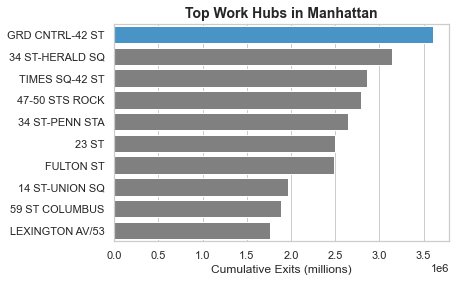

In [63]:
# Graph Exits by Manhattan Station
exits_palette = {key: "gray" if key != "GRD CNTRL-42 ST" else "#3498db" for key in stations_hourly_top10["STATION"].unique()}

sns.barplot(stations_hourly_top10['HOURLY_EXITS'],stations_hourly_top10['STATION'], orient = "h", palette = exits_palette)
sns.set(style = "whitegrid")
plt.xlabel("Cumulative Exits (millions)")
plt.ylabel("")
plt.title("Top Work Hubs in Manhattan", weight="bold", fontsize="14");

In [35]:
# find which lines commute to Grand Central 
df_final[df_final['STATION'] == 'GRD CNTRL-42 ST']["LINENAME"].unique()

array(['4567S'], dtype=object)

In [36]:
# We choose 1 line from these: we chose 4 to start with 
df_final[df_final['LINENAME'].str.contains('4')].STATION.unique() 

array(['CROWN HTS-UTICA', 'FRANKLIN AV', 'ATL AV-BARCLAY', 'NEVINS ST',
       'BOROUGH HALL', 'WOODLAWN', 'MOSHOLU PKWY', 'BEDFORD PK BLVD',
       'KINGSBRIDGE RD', 'FORDHAM RD', '183 ST', 'BURNSIDE AV', '176 ST',
       'MT EDEN AV', '170 ST', '167 ST', '161/YANKEE STAD',
       '149/GRAND CONC', '138/GRAND CONC', '125 ST', '86 ST', '59 ST',
       'GRD CNTRL-42 ST', '14 ST-UNION SQ', 'BROOKLYN BRIDGE',
       'FULTON ST', 'WALL ST', 'BOWLING GREEN', 'BOTANIC GARDEN',
       'CHAMBERS ST'], dtype=object)

In [37]:
df_final[df_final['LINENAME'].str.contains('5')].STATION.unique() 

array(['EASTCHSTER/DYRE', 'BAYCHESTER AV', 'GUN HILL RD', 'PELHAM PKWY',
       'MORRIS PARK', 'FLATBUSH AV-B.C', 'NEWKIRK AV', 'BEVERLY RD',
       'CHURCH AV', 'WINTHROP ST', 'STERLING ST', 'PRESIDENT ST',
       'FRANKLIN AV', 'ATL AV-BARCLAY', 'NEVINS ST', 'BOROUGH HALL',
       'NEREID AV', '233 ST', '225 ST', '219 ST', 'BURKE AV',
       'ALLERTON AV', 'BRONX PARK EAST', 'E 180 ST', 'WEST FARMS SQ',
       '174 ST', 'FREEMAN ST', 'SIMPSON ST', 'INTERVALE AV',
       'PROSPECT AV', 'JACKSON AV', '3 AV-149 ST', '149/GRAND CONC',
       '138/GRAND CONC', '125 ST', '86 ST', '59 ST', 'GRD CNTRL-42 ST',
       '14 ST-UNION SQ', 'BROOKLYN BRIDGE', 'FULTON ST', 'WALL ST',
       'BOWLING GREEN', 'BOTANIC GARDEN', 'CHAMBERS ST'], dtype=object)

In [38]:
# Declare list of stations in Brooklyn with access to lines 4 & 5 
stations_4_5 = ['CROWN HTS-UTICA', 'FRANKLIN AV', 'ATL AV-BARCLAY', 'NEVINS ST','BOROUGH HALL', 'PRESIDENT ST', 'STERLING ST','WINTHROP ST', 'CHURCH AV', 'BEVERLY RD', 'NEWKIRK AV']

In [39]:
df_4_5_Brooklyn = df_final[df_final['STATION'].isin(stations_4_5)] 

In [40]:
df_4_5_Brooklyn.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY_NAME,Turnstile,PREV_DATE,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS
202139,R644,R135,01-06-01,NEWKIRK AV,25,IRT,11/29/2019,08:00:00,REGULAR,583454,10284018,2019-11-29 08:00:00,Friday,R644R13501-06-01,11/29/2019,583470.0,10284160.0,16.0,142.0
202133,R644,R135,01-06-01,NEWKIRK AV,25,IRT,11/28/2019,08:00:00,REGULAR,583425,10283246,2019-11-28 08:00:00,Thursday,R644R13501-06-01,11/28/2019,583435.0,10283362.0,10.0,116.0
202126,R644,R135,01-06-01,NEWKIRK AV,25,IRT,11/27/2019,09:40:03,REGULAR,583335,10281502,2019-11-27 09:40:03,Wednesday,R644R13501-06-01,11/27/2019,583351.0,10281628.0,16.0,126.0
202125,R644,R135,01-06-01,NEWKIRK AV,25,IRT,11/27/2019,08:00:00,REGULAR,583325,10281419,2019-11-27 08:00:00,Wednesday,R644R13501-06-01,11/27/2019,583335.0,10281502.0,10.0,83.0
202119,R644,R135,01-06-01,NEWKIRK AV,25,IRT,11/26/2019,08:00:00,REGULAR,583235,10279466,2019-11-26 08:00:00,Tuesday,R644R13501-06-01,11/26/2019,583267.0,10279692.0,32.0,226.0


In [41]:
# Get Entries by Station
work_week_entries = \
(df_4_5_Brooklyn.groupby(['STATION'])['HOURLY_ENTRIES'].sum()
                 .reset_index())

work_week_entries.sort_values(by = 'HOURLY_ENTRIES', ascending = True, inplace = True)

In [42]:
work_week_entries

,STATION,HOURLY_ENTRIES
10,WINTHROP ST,121013.0
7,NEWKIRK AV,124557.0
8,PRESIDENT ST,131114.0
1,BEVERLY RD,132692.0
9,STERLING ST,142206.0
6,NEVINS ST,221255.0
5,FRANKLIN AV,609944.0
4,CROWN HTS-UTICA,761424.0
2,BOROUGH HALL,773457.0
3,CHURCH AV,943920.0


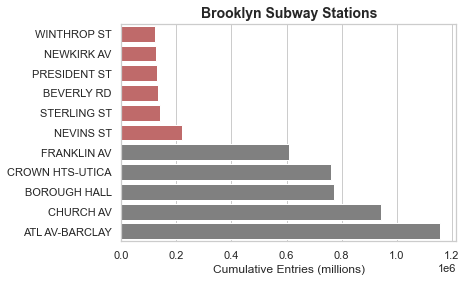

In [64]:
# Graph Stations by Entries
red_list = ["WINTHROP ST","NEWKIRK AV", "PRESIDENT ST", "BEVERLY RD","STERLING ST","NEVINS ST"] 
entries_palette = {key: "gray" if key not in red_list else "#CD5C5C" for key in work_week_entries["STATION"].unique()}

sns.barplot(work_week_entries['HOURLY_ENTRIES'],work_week_entries['STATION'], orient = "h", palette = entries_palette)
sns.set(style="whitegrid")
plt.xlabel("Cumulative Entries (millions)")
plt.ylabel("")
plt.title("Brooklyn Subway Stations", weight="bold", fontsize="14");

In [47]:
work_week_entries.head()

,STATION,HOURLY_ENTRIES
10,WINTHROP ST,121013.0
7,NEWKIRK AV,124557.0
8,PRESIDENT ST,131114.0
1,BEVERLY RD,132692.0
9,STERLING ST,142206.0


In [48]:
stations_4_5

['CROWN HTS-UTICA',
 'FRANKLIN AV',
 'ATL AV-BARCLAY',
 'NEVINS ST',
 'BOROUGH HALL',
 'PRESIDENT ST',
 'STERLING ST',
 'WINTHROP ST',
 'CHURCH AV',
 'BEVERLY RD',
 'NEWKIRK AV']

In [49]:
# Declare dictionaries with subway stations along the 4,5 line

stations_4_5_nhoods_inc = {"Crown Heights North":[["CROWN HTS-UTICA"],37104],
                              "Crown Heights South":[["PRESIDENT ST"],41745],
                              "East Flatbush":[['Beverly RD'], 50889],
                              'Flatbush':[['Church Av','NewKirk Av'],45332],
                              "Prospect Lefferts Gardens":[["FRANKLIN AV","STERLING ST", "WINTHROP ST"],42462],
                              "Downtown Brooklyn":[["ATL AV-BARCLAY","NEVINS ST","BOROUGH HALL"],84945]
                             }

In [50]:
stations_4_5_inc = {"CROWN HTS-UTICA":37104,
                              "PRESIDENT ST":41745,
                              "BEVERLY RD":50889,
                              "CHURCH AV": 45332,
                               "NEWKIRK AV":45332,
                              "FRANKLIN AV":42462,
                               "STERLING ST": 42462,
                                "WINTHROP ST":42462,
                                "ATL AV-BARCLAY":84945,
                                "NEVINS ST":84945,
                                "BOROUGH HALL":84945
                             }

In [51]:
stations_4_5_nhoods = {"CROWN HTS-UTICA":"Crown Heights North",
                              "PRESIDENT ST":"Crown Heights South",
                              "BEVERLY RD":"East Flatbush",
                              "CHURCH AV": "Flatbush",
                               "NEWKIRK AV":"Flatbush",
                              "FRANKLIN AV": "Prospect Lefferts Gardens",
                               "STERLING ST": "Prospect Lefferts Gardens",
                                "WINTHROP ST":"Prospect Lefferts Gardens",
                                "ATL AV-BARCLAY":"Downtown Brooklyn",
                                "NEVINS ST":"Downtown Brooklyn",
                                "BOROUGH HALL":"Downtown Brooklyn"
                             }

In [54]:
# Add Neighborhood and Income data to dataframe
work_week_entries["N_HOOD"] = work_week_entries['STATION'].map(stations_4_5_nhoods)
work_week_entries["INCOME"] = work_week_entries['STATION'].map(stations_4_5_inc)                                             

,STATION,HOURLY_ENTRIES,INCOME,N_HOOD
10,WINTHROP ST,121013.0,42462,Prospect Lefferts Gardens
7,NEWKIRK AV,124557.0,45332,Flatbush
8,PRESIDENT ST,131114.0,41745,Crown Heights South
1,BEVERLY RD,132692.0,50889,East Flatbush
9,STERLING ST,142206.0,42462,Prospect Lefferts Gardens
6,NEVINS ST,221255.0,84945,Downtown Brooklyn
5,FRANKLIN AV,609944.0,42462,Prospect Lefferts Gardens
4,CROWN HTS-UTICA,761424.0,37104,Crown Heights North
2,BOROUGH HALL,773457.0,84945,Downtown Brooklyn
3,CHURCH AV,943920.0,45332,Flatbush


In [55]:
# Create DataFrame grouped by Neighborhood
df_norm_n_hood = pd.DataFrame(work_week_entries.groupby("N_HOOD")[["HOURLY_ENTRIES", "INCOME"]]
                                    .agg({"HOURLY_ENTRIES": "sum",
                                          "INCOME": "mean",
                                         })
                              )

# Scale data
df_norm_n_hood["INCOME"] = (df_norm_n_hood["INCOME"] - df_norm_n_hood["INCOME"].mean()) / (df_norm_n_hood["INCOME"].max() - df_norm_n_hood["INCOME"].min())
df_norm_n_hood["ENTRIES"] = (df_norm_n_hood["HOURLY_ENTRIES"] - df_norm_n_hood["HOURLY_ENTRIES"].mean()) / (df_norm_n_hood["HOURLY_ENTRIES"].max() - df_norm_n_hood["HOURLY_ENTRIES"].min())


In [56]:
# Drop HOURLY_ENTRIES
df_norm_n_hood.drop(columns = "HOURLY_ENTRIES", inplace = True)
df_norm_n_hood

,INCOME,ENTRIES
N_HOOD,,
Crown Heights North,-0.278189,-0.045425
Crown Heights South,-0.181180,-0.357224
Downtown Brooklyn,0.721811,0.642776
East Flatbush,0.009953,-0.356443
Flatbush,-0.106202,0.106466
Prospect Lefferts Gardens,-0.166193,0.009849


In [57]:
# Create DataFrame grouped by Station
df_norm_station = pd.DataFrame(work_week_entries.groupby("STATION")[["HOURLY_ENTRIES","INCOME"]]
                               .agg({'HOURLY_ENTRIES': 'sum',
                                     'INCOME': 'mean'
                                    })
                              )
# Scale data
df_norm_station["INCOME"] = (df_norm_station["INCOME"] - df_norm_station["INCOME"].mean()) / (df_norm_station["INCOME"].max() - df_norm_station["INCOME"].min())
df_norm_station["ENTRIES"] = (df_norm_station["HOURLY_ENTRIES"] - df_norm_station["HOURLY_ENTRIES"].mean()) / (df_norm_station["HOURLY_ENTRIES"].max() - df_norm_station["HOURLY_ENTRIES"].min())


In [58]:
# Drop HOURLY_ENTRIES and view new df
df_norm_station.drop(columns = "HOURLY_ENTRIES", inplace = True)
df_norm_station

,INCOME,ENTRIES
STATION,,
ATL AV-BARCLAY,0.630444,0.667865
BEVERLY RD,-0.081414,-0.320872
BOROUGH HALL,0.630444,0.297078
CHURCH AV,-0.197569,0.461472
CROWN HTS-UTICA,-0.369556,0.285474
FRANKLIN AV,-0.257560,0.139387
NEVINS ST,0.630444,-0.235462
NEWKIRK AV,-0.197569,-0.328717
PRESIDENT ST,-0.272547,-0.322394


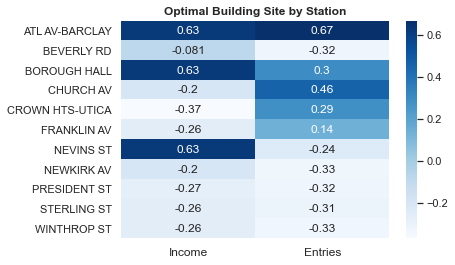

In [59]:
sns.heatmap(df_norm_station[["INCOME","ENTRIES"]], annot = True, cmap = "Blues")
plt.title("Optimal Building Site by Station", weight="bold")
plt.xticks(ticks=[0.5,1.5],labels=["Income", "Entries"], fontsize=12)
plt.ylabel("");

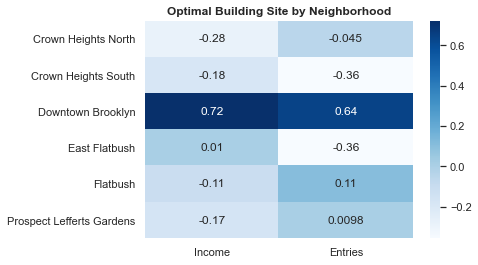

In [60]:
sns.heatmap(df_norm_n_hood[["INCOME","ENTRIES"]], annot = True, cmap = "Blues")
plt.xticks(ticks=[0.5,1.5],labels = ["Income", "Entries"])
plt.title("Optimal Building Site by Neighborhood", weight = "bold")
plt.ylabel("",rotation=90, labelpad=0);